# Data Wrangling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")
#!pip install pandas_datareader
import pandas_datareader.data as web

### Data Scraping

In [2]:
start= pd.to_datetime('2016-01-01')
end= pd.to_datetime('2021-03-07')

btc = web.DataReader('BTC-USD','yahoo',start, end)
eth = web.DataReader('ETH-USD','yahoo',start, end)
ltc = web.DataReader('LTC-USD','yahoo',start, end)
dash = web.DataReader('DASH-USD','yahoo',start, end)

In [3]:
btc.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900.0,434.334015
2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600.0,433.437988
2016-01-03,433.743011,424.705994,433.578003,430.010986,39633800.0,430.010986
2016-01-04,434.516998,429.084015,430.061005,433.091003,38477500.0,433.091003
2016-01-05,434.182007,429.675995,433.069000,431.959991,34522600.0,431.959991


In [4]:
#eliminando outras colunas para ficar apenas Close
btc.drop(['High','Low','Open','Volume','Adj Close'], axis=1,inplace=True)
eth.drop(['High','Low','Open','Volume','Adj Close'], axis=1,inplace=True)
ltc.drop(['High','Low','Open','Volume','Adj Close'], axis=1,inplace=True)
dash.drop(['High','Low','Open','Volume','Adj Close'], axis=1,inplace=True)
#concatenar para os ativos para 'Close'
df = pd.concat([btc,eth,ltc,dash],axis=1) 
#mudar os headers da colunas
df.columns = ['BTC','ETH','LTC','DASH']

In [5]:
#salvar um um arquivo CSV
df.to_csv("cryptos.csv")

In [6]:
df.BTC.head()

Date
2016-01-01    434.334015
2016-01-02    433.437988
2016-01-03    430.010986
2016-01-04    433.091003
2016-01-05    431.959991
Name: BTC, dtype: float64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1890 entries, 2016-01-01 to 2021-03-08
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BTC     1890 non-null   float64
 1   ETH     1890 non-null   float64
 2   LTC     1890 non-null   float64
 3   DASH    1890 non-null   float64
dtypes: float64(4)
memory usage: 73.8 KB


# Simple Moving Average (SMA) Optimizer

In [8]:
class SMABacktester(): # with ptc 
    ''' Class for the vectorized backtesting of SMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    SMA_S: int
        time window in days for shorter SMA
    SMA_L: int
        time window in days for longer SMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new SMA parameters
        
    test_strategy:
        runs the backtest for the SMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates SMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two SMA parameters
    '''
    
    def __init__(self, symbol, SMA_S, SMA_L, start, end, tc):
        self.symbol = symbol
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SMABacktester(symbol = {}, SMA_S = {}, SMA_L = {}, start = {}, end = {})".format(self.symbol, self.SMA_S, self.SMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("cryptos.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA_S"] = raw["price"].rolling(self.SMA_S).mean()
        raw["SMA_L"] = raw["price"].rolling(self.SMA_L).mean()
        self.data = raw
        
    def set_parameters(self, SMA_S = None, SMA_L = None):
        ''' Updates SMA parameters and resp. time series.
        '''
        if SMA_S is not None:
            self.SMA_S = SMA_S
            self.data["SMA_S"] = self.data["price"].rolling(self.SMA_S).mean()
        if SMA_L is not None:
            self.SMA_L = SMA_L
            self.data["SMA_L"] = self.data["price"].rolling(self.SMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA_S = {} | SMA_L = {} | TC = {}".format(self.symbol, self.SMA_S, self.SMA_L, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, SMA):
        ''' Updates SMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        SMA: tuple
            SMA parameter tuple
        '''
        self.set_parameters(int(SMA[0]), int(SMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA1_range, SMA2_range):
        ''' Finds global maximum given the SMA parameter ranges.

        Parameters
        ==========
        SMA1_range, SMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA1_range, SMA2_range), finish=None)
        return opt, -self.update_and_run(opt)

In [9]:
#recent history...MAs are short, no hystorical data
tester_S = SMABacktester("BTC", 50, 100, "2017-01-01", "2021-03-07", 0)
tester_S.optimize_parameters((9, 50, 1), (50, 100, 1))

(array([ 9., 91.]), 141.518067)

In [10]:
tester_S.results

,price,returns,SMA_S,SMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2017-04-01,1102.170044,0.019857,1039.253791,1036.351768,1,-0.019857,0.0,1.020056,0.980339
2017-04-02,1143.810059,0.037084,1058.257243,1037.693087,1,0.037084,0.0,1.058593,1.017376
2017-04-03,1133.250000,-0.009275,1076.760023,1038.675615,1,-0.009275,0.0,1.048820,1.007983
2017-04-04,1124.780029,-0.007502,1085.538913,1038.346495,1,-0.007502,0.0,1.040981,1.000449
2017-04-05,1182.680054,0.050196,1100.597805,1040.206935,1,0.050196,0.0,1.094567,1.051949
...,...,...,...,...,...,...,...,...,...
2021-03-03,50538.242188,0.043665,47982.007378,34773.699562,1,0.043665,0.0,46.773015,139.670698
2021-03-04,48561.167969,-0.039906,47952.756510,35093.653073,1,-0.039906,0.0,44.943237,134.206730
2021-03-05,48927.304688,0.007511,47866.309028,35425.823832,1,0.007511,0.0,45.282096,135.218609


In [11]:
tester_S.test_strategy()
#few trades because there is no hystorical data.
#hystorical data is quality!!!

(141.518067,
 94.126405,
 0.0    1416
 2.0      16
 Name: trades, dtype: int64)

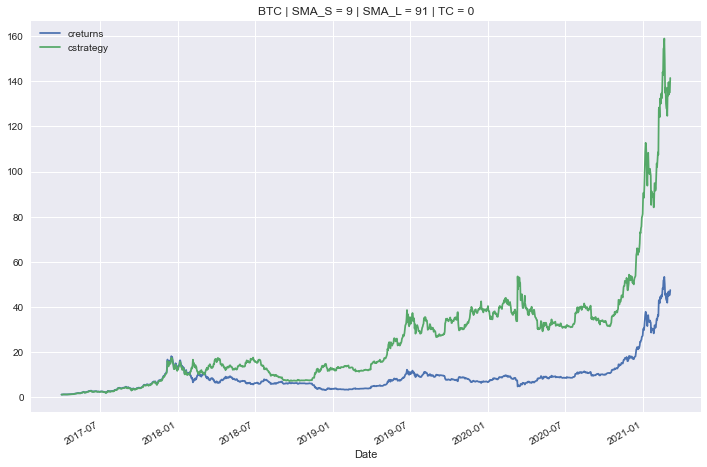

In [12]:
tester_S.plot_results()

# Exponential Moving Average (EMA) Optimizer

In [13]:
class EMABacktester(): 
    ''' Class for the vectorized backtesting of EMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    EMA_S: int
        time window in days for shorter EMA
    EMA_L: int
        time window in days for longer EMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new EMA parameters
        
    test_strategy:
        runs the backtest for the EMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates EMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two EMA parameters
    '''
    
    def __init__(self, symbol, EMA_S, EMA_L, start, end, tc):
        self.symbol = symbol
        self.EMA_S = EMA_S
        self.EMA_L = EMA_L
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "EMABacktester(symbol = {}, EMA_S = {}, EMA_L = {}, start = {}, end = {})".format(self.symbol, self.EMA_S, self.EMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("cryptos.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["EMA_S"] = raw["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        raw["EMA_L"] = raw["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean() 
        self.data = raw
        
    def set_parameters(self, EMA_S = None, EMA_L = None):
        ''' Updates EMA parameters and resp. time series.
        '''
        if EMA_S is not None:
            self.EMA_S = EMA_S
            self.data["EMA_S"] = self.data["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        if EMA_L is not None:
            self.EMA_L = EMA_L
            self.data["EMA_L"] = self.data["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["EMA_S"] > data["EMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | EMA_S = {} | EMA_L = {} | TC = {}".format(self.symbol, self.EMA_S, self.EMA_L, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, EMA):
        ''' Updates EMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        EMA: tuple
            EMA parameter tuple
        '''
        self.set_parameters(int(EMA[0]), int(EMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, EMA1_range, EMA2_range):
        ''' Finds global maximum given the EMA parameter ranges.

        Parameters
        ==========
        EMA1_range, EMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (EMA1_range, EMA2_range), finish=None)
        return opt, -self.update_and_run(opt)

In [14]:
tester_E = EMABacktester("BTC", 50, 100, "2017-01-01", "2021-03-07", 0)
tester_E.optimize_parameters((9, 50, 1), (50, 100, 1))

(array([35., 50.]), 171.180427)

In [15]:
tester_E.results

,price,returns,EMA_S,EMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2017-02-20,1079.979980,0.030183,995.380880,984.543994,1,0.030183,0.0,1.030643,1.030643
2017-02-21,1115.300049,0.032181,1002.402483,990.403510,1,0.032181,0.0,1.064350,1.064350
2017-02-22,1117.439941,0.001917,1009.118119,996.064655,1,0.001917,0.0,1.066392,1.066392
2017-02-23,1166.719971,0.043156,1018.292679,1003.629145,1,0.043156,0.0,1.113421,1.113421
2017-02-24,1173.680054,0.005948,1027.314346,1011.128519,1,0.005948,0.0,1.120063,1.120063
...,...,...,...,...,...,...,...,...,...
2021-03-03,50538.242188,0.043665,45506.484804,42827.522792,1,0.043665,0.0,48.229496,168.945848
2021-03-04,48561.167969,-0.039906,45676.189425,43052.371623,1,-0.039906,0.0,46.342741,162.336626
2021-03-05,48927.304688,0.007511,45856.806939,43282.761155,1,0.007511,0.0,46.692152,163.560595


In [16]:
tester_E.test_strategy()

(171.180427,
 122.313019,
 0.0    1461
 2.0      12
 Name: trades, dtype: int64)

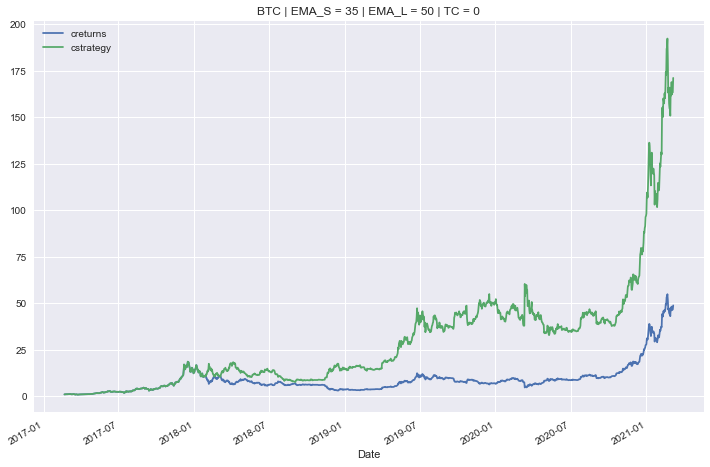

In [17]:
tester_E.plot_results()

# SMA x EMA Optimizer

In [18]:
class SMAEMABacktester(): 
    ''' Class for the vectorized backtesting of SMA/EMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    SMA: int
        time window in days for SMA
    EMA: int
        time window in days for EMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new SMA/EMA parameters
        
    test_strategy:
        runs the backtest for the SMA/EMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates EMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two SAM/EMA parameters
    '''
    
    def __init__(self, symbol, SMA, EMA, start, end, tc):
        self.symbol = symbol
        self.SMA = SMA
        self.EMA = EMA
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SMAEMABacktester(symbol = {}, SMA = {}, EMA = {}, start = {}, end = {})".format(self.symbol, self.SMA, self.EMA, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("cryptos.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA"] = raw["price"].rolling(self.SMA).mean() 
        raw["EMA"] = raw["price"].ewm(span = self.EMA, min_periods = self.EMA).mean() 
        self.data = raw
        
    def set_parameters(self, SMA = None, EMA = None):
        ''' Updates SMA/EMA parameters and resp. time series.
        '''
        if SMA is not None:
            self.SMA = SMA
            self.data["SMA"] = self.data["price"].rolling(self.SMA).mean() 
        if EMA is not None:
            self.EMA = EMA
            self.data["EMA"] = self.data["price"].ewm(span = self.EMA, min_periods = self.EMA).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["EMA"] > data["SMA"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA = {} | EMA = {} | TC = {}".format(self.symbol, self.SMA, self.EMA, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, SMAEMA):
        ''' Updates SMA/EMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        SMAEMA: tuple
            SMA/EMA parameter tuple
        '''
        self.set_parameters(int(SMAEMA[0]), int(SMAEMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA_range, EMA_range):
        ''' Finds global maximum given the SMA/EMA parameter ranges.

        Parameters
        ==========
        SMA_range, EMA_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA_range, EMA_range), finish=None)
        return opt, -self.update_and_run(opt)

In [19]:
tester_SE = SMAEMABacktester("BTC", 20, 20, "2017-01-01", "2021-03-07", 0)
tester_SE.optimize_parameters((9, 100, 1), (9, 100, 1))

(array([23., 20.]), 1203.058581)

In [20]:
tester_SE.results

,price,returns,SMA,EMA,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2017-01-24,892.687012,-0.031237,908.405518,895.809543,-1,0.031237,0.0,0.969246,1.031730
2017-01-25,901.541992,0.009871,903.179082,896.404201,-1,-0.009871,0.0,0.978860,1.021596
2017-01-26,917.585999,0.017640,897.689780,898.582991,1,-0.017640,2.0,0.996280,1.003734
2017-01-27,919.750000,0.002356,887.473259,900.743787,1,0.002356,0.0,0.998630,1.006101
2017-01-28,921.590027,0.001999,883.482390,902.857370,1,0.001999,0.0,1.000628,1.008114
...,...,...,...,...,...,...,...,...,...
2021-03-03,50538.242188,0.043665,49529.695482,48111.399785,-1,-0.043665,0.0,54.872511,1218.970958
2021-03-04,48561.167969,-0.039906,49620.132982,48154.234850,-1,0.039906,0.0,52.725878,1268.599008
2021-03-05,48927.304688,0.007511,49794.442595,48227.860549,-1,-0.007511,0.0,53.123416,1259.105726


In [21]:
tester_SE.test_strategy()

(1203.058581,
 1147.460293,
 0.0    1436
 2.0      64
 Name: trades, dtype: int64)

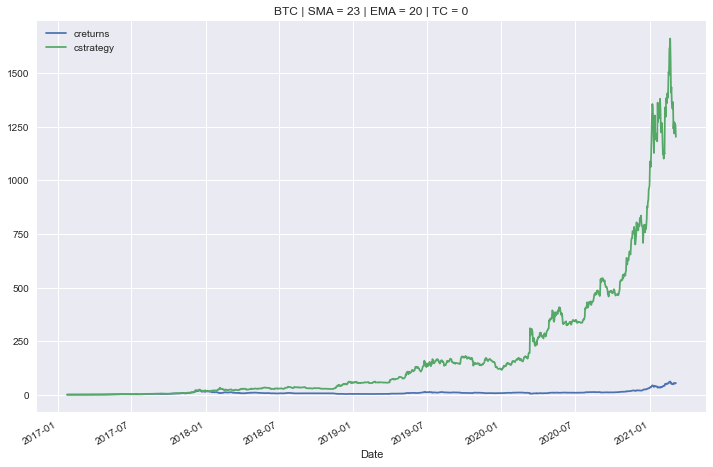

In [22]:
tester_SE.plot_results()